# Actividad Integradora 3

hecho por Jesús Omar Cuenca Espino A01378844

### Imports

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import random as rn
import os
import warnings
import matplotlib.pyplot as plt
warnings.simplefilter(action="ignore", category=FutureWarning)
%matplotlib inline

message = "Escriba la letra 'y' en caso de querer usar la GPU\nEsto reducira el tiempo de ejecucion, pero puede afectar la reproducibilidad de los resultados\n"

# Lines needed for Reproducible results
os.environ['PYTHONHASHSEED'] = '0'
physical_devices = tf.config.experimental.list_physical_devices("GPU")
# print("Num GPUs Available: ", len(physical_devices))
if(len(physical_devices) > 0 and input(message) == "y"):
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    os.environ['CUDA_VISIBLE_DEVICES'] = ''

np.random.seed(42)
rn.seed(91939)
tf.random.set_seed(911)

### Definimos los tipos de vehiculo que tenemos

In [2]:
train_path = "data/train"
valid_path = "data/validation"
test_path = "data/test"

In [3]:
TYPES_OF_VEHICLES = ("airplane","bicycle","bus","car","motorcycle")

#### Verificamos su existencia

In [4]:
assert os.path.isdir("data")
os.chdir("data/")

VEHICLES_EXTENSION = [[],[],[]]

try:
    for t in TYPES_OF_VEHICLES:
        assert os.path.isdir(f"train/{t}")
        assert os.path.isdir(f"test/{t}")
        assert os.path.isdir(f"validation/{t}")
        VEHICLES_EXTENSION[0].append(len(os.listdir(f"train/{t}")))
        VEHICLES_EXTENSION[1].append(len(os.listdir(f"test/{t}")))
        VEHICLES_EXTENSION[2].append(len(os.listdir(f"validation/{t}")))
except AssertionError:
    print("There is a missing Data folder")

os.chdir("..")

#### Graficamos la distribucion de datos

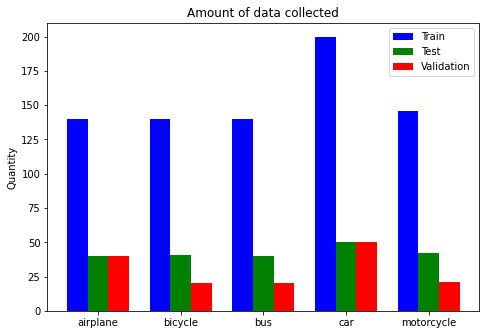

In [5]:
X = np.arange(len(TYPES_OF_VEHICLES))
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X - 0.25, VEHICLES_EXTENSION[0], color = 'b', width = 0.25)
ax.bar(X + 0.00, VEHICLES_EXTENSION[1], color = 'g', width = 0.25)
ax.bar(X + 0.25, VEHICLES_EXTENSION[2], color = 'r', width = 0.25)
ax.set_ylabel('Quantity')
ax.set_title('Amount of data collected')
ax.set_xticks(X)
ax.set_xticklabels(TYPES_OF_VEHICLES)
ax.legend(labels=['Train', 'Test',"Validation"])
plt.show()

#### Creamos los batches de entrenamiento, validation y testing

In [6]:
print("############# TRAINING BATCHES ###############")
train_batches = \
 ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=TYPES_OF_VEHICLES, batch_size=10)
print("############# VALIDATION BATCHES ###############")
valid_batches = \
 ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=TYPES_OF_VEHICLES, batch_size=10)
print("############# TESTING BATCHES ###############")
test_batches = \
 ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=TYPES_OF_VEHICLES, batch_size=10, shuffle=False)

############# TRAINING BATCHES ###############
Found 766 images belonging to 5 classes.
############# VALIDATION BATCHES ###############
Found 151 images belonging to 5 classes.
############# TESTING BATCHES ###############
Found 212 images belonging to 5 classes.


In [7]:
imgs, labels = next(train_batches)

In [8]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

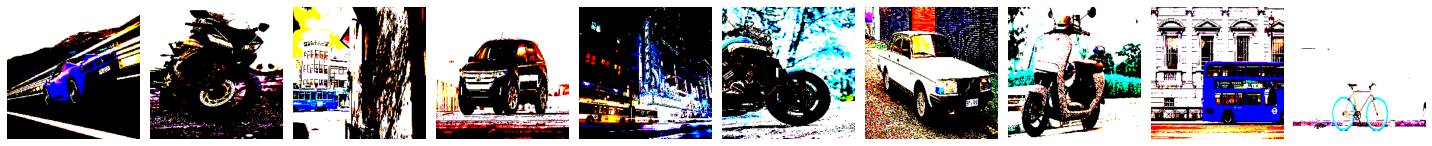

[[0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]]


In [9]:
plotImages(imgs)
print(labels)

### Descargamos el modelo de VGG16 para usar de base

In [10]:
# This is the automated way to download the VGG16 model, but for some reason
# it is not working for something related to an SSL issue.
# So a hack around this issue is to explicetly create an SSL context like so
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Solution found in >> https://github.com/fchollet/deep-learning-models/issues/33#issuecomment-397257502

vgg16_model = tf.keras.applications.VGG16()

In [11]:
model = Sequential()
for layer in vgg16_model.layers[:-2]:
    model.add(layer)

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

#### Convertimos el modelo a uno para Transfer Learning

Congelamos todas las capas del modelo actual

In [13]:
# Block the model layers to be not trainable
for layer in model.layers:
    layer.trainable = False

## Fine Tuning

Agregamos las capas que necesitemos para el Fine tuning

In [14]:
model.add(Dense(units=2048, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation="relu"))
model.add(Dense(units=1024, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation="relu"))
# model.add(Dense(units=10, activation="relu"))
model.add(Dense(units=len(TYPES_OF_VEHICLES), activation="softmax"))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

## Entrenamiento del modelo

In [16]:
model.compile(optimizer=Adam(learning_rate=0.0005), loss="categorical_crossentropy", metrics=["accuracy"])

In [17]:
history = model.fit(x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=valid_batches,
    validation_steps=len(valid_batches),
    epochs=10,
    verbose=2
)

Epoch 1/10
77/77 - 168s - loss: 32.8762 - accuracy: 0.9060 - val_loss: 25.6746 - val_accuracy: 0.9801
Epoch 2/10
77/77 - 166s - loss: 22.1848 - accuracy: 0.9778 - val_loss: 19.1529 - val_accuracy: 0.9603
Epoch 3/10
77/77 - 166s - loss: 16.3990 - accuracy: 0.9896 - val_loss: 14.7459 - val_accuracy: 0.9868
Epoch 4/10
77/77 - 167s - loss: 12.4537 - accuracy: 0.9817 - val_loss: 12.1357 - val_accuracy: 0.9536
Epoch 5/10
77/77 - 167s - loss: 9.9850 - accuracy: 0.9752 - val_loss: 9.5580 - val_accuracy: 0.9536
Epoch 6/10
77/77 - 166s - loss: 8.1799 - accuracy: 0.9791 - val_loss: 8.1641 - val_accuracy: 0.9669
Epoch 7/10
77/77 - 167s - loss: 6.3942 - accuracy: 0.9896 - val_loss: 6.2178 - val_accuracy: 0.9603
Epoch 8/10
77/77 - 167s - loss: 4.8922 - accuracy: 0.9987 - val_loss: 4.5140 - val_accuracy: 0.9735
Epoch 9/10
77/77 - 167s - loss: 3.8093 - accuracy: 1.0000 - val_loss: 3.5766 - val_accuracy: 0.9735
Epoch 10/10
77/77 - 167s - loss: 2.9824 - accuracy: 1.0000 - val_loss: 2.8519 - val_accuracy

### Grafica del desempeño a través de los Epochs

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


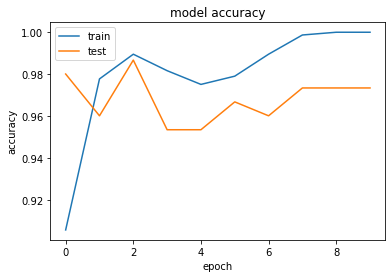

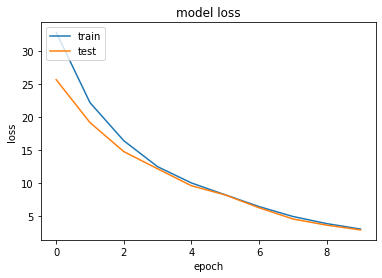

In [18]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Los resultados son buenos porque el modelo VGG16 ya habia sido previamente entrenado con un data set de ImageNet

### Probando contra el testing set el modelo reentrenado

In [19]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

### Graficando los resultados

In [20]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

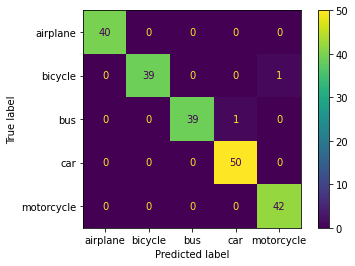

In [21]:
cm_plot_labels = list(test_batches.class_indices.keys())
result = ConfusionMatrixDisplay(cm, display_labels=cm_plot_labels)
result.plot()